In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [2]:
'''
Creating a random graph

graph contains n destinations and m chargers

the random graph is completely connected
'''
deep_reload(src)

seed = 125396749
n = 15
m = 85
speeds = [105]
chargers = list(range(1, 6))
scale = (1e6, 1e6)

graph = src.rng.random_completely_connected_graph(
    n, m, speeds = speeds, scale = scale, seed = seed, chargers = chargers,
)

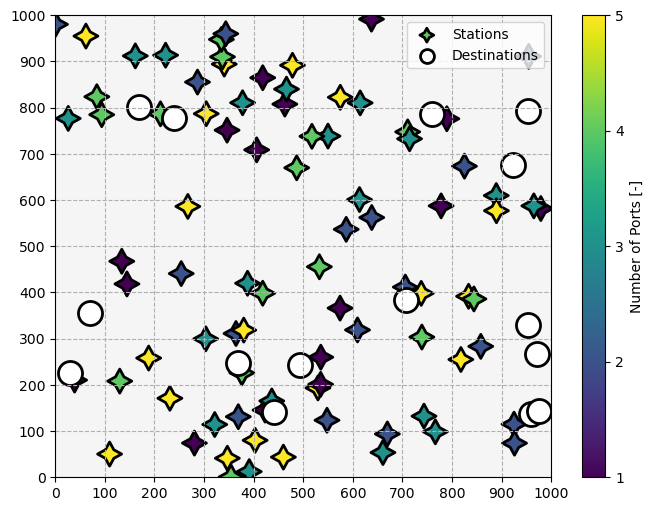

In [3]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [n for n in graph.nodes if 'destination' in n]
stations = [n for n in graph.nodes if 'station' in n]

destinations = src.graph.subgraph(graph, destinations)
stations = src.graph.subgraph(graph, stations)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc',
    'scatter': {
        's': 300,
        'ec': 'k',
        'lw': 2,
        'marker': (4, 1, 0),
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Number of Ports [-]',
        'ticks': list(range(1, 6)),
    },
}

src.figures.plot_graph(
   stations, ax = ax, **kw,
)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'fc': 'white',
        'ec': 'k',
        'lw': 2,
        'zorder': 1,
        'label': 'Destinations',
    },
}

src.figures.plot_graph(
   destinations, ax = ax, **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend(loc = 1)

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_number_chargers.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [4]:
'''
Adding station objects
'''
deep_reload(src)

kw = {
    'cases': 100,
    'reliability': .95,
    'rng': np.random.default_rng(seed),
    'base_delay': 300,
}

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **kw,
        )

    else:

        node['population'] = 1e6



In [5]:
weighted = {k: v['population'] for k, v in graph._node.items() if v['type'] == 'destination'}
unweighted = {k: 1 for k, v in graph._node.items() if v['type'] == 'destination'}

In [6]:
'''
Running with Dijkstra with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (0, .2),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'dijkstra',
    'origins': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.all_pairs_shortest_paths(
    graph, **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')

 [------------->] (15/15) 100.00%, 1.64 it/s, 9.75 s elapsed, 0.00 s remainingExecuted in 9.7472 seconds


In [7]:
deep_reload(src)

current = src.routing.current(
    values,
    origins = weighted,
    destinations = weighted,
    constant = 1 * 3600,
)

impedance = src.routing.impedance(
    values,
    origins = unweighted,
    destinations = unweighted,
    constant = 1 / 3600,
)

print(f'current: {current:.4f}, impedance: {impedance:.4f}')

current: 54486.3982, impedance: 2.9195


In [29]:
'''
Adding station objects
'''
deep_reload(src)

kw = {
    'cases': 100,
    'reliability': .95,
    'rng': np.random.default_rng(seed),
    'base_delay': 300,
}

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **kw,
        )

    else:

        node['population'] = 1e6



In [30]:
'''
Running with Dijkstra with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (0, .1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'dijkstra',
    'origins': ['destination_0'],
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.6087 seconds


In [31]:
n_chargers = 0
n_stations = 0

for path in paths.values():
    for node in path:

        node = graph._node[node]

        if node.get('n_dcfc', 0) > 0:

            n_stations += 1
            n_chargers += node['n_dcfc']

n_chargers, n_stations, n_chargers / n_stations

(117, 31, 3.774193548387097)

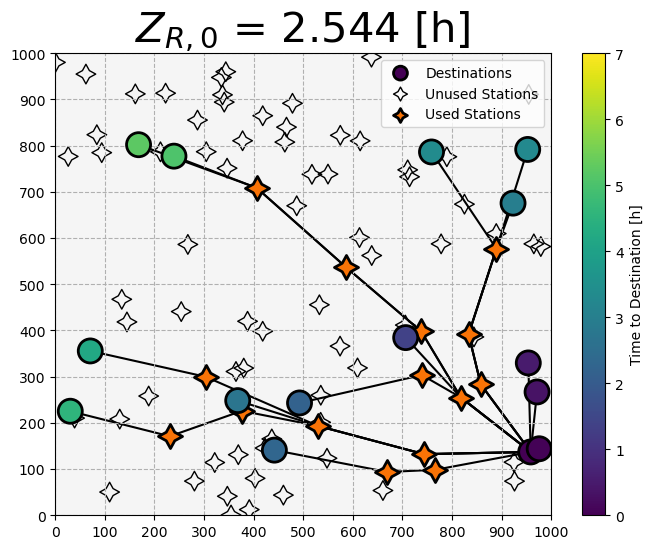

In [32]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

expectation = lambda x: super_quantile(x, vehicle.risk_attitude)
# expectation = lambda x: x.mean()

impedance = src.routing.impedance(
    {'destination_0': values},
    origins = {'destination_0': unweighted['destination_0']},
    destinations = unweighted,
    constant = 1 / 3600,
    expectation = expectation
)

src.figures.plot_route_tree(
    ax, graph,
    
    values = {k: expectation(v['time'])/ 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$Z_{R,0}$' + f' = {impedance:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_high_reliability_aggressive_perceived.png',
    bbox_inches = 'tight',
    dpi = 300,
)

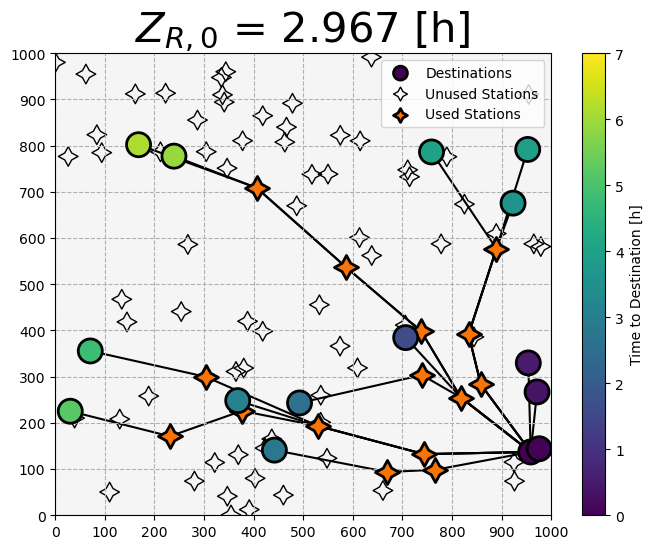

In [33]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

# expectation = lambda x: super_quantile(x, vehicle.risk_attitude)
expectation = lambda x: x.mean()

impedance = src.routing.impedance(
    {'destination_0': values},
    origins = {'destination_0': unweighted['destination_0']},
    destinations = unweighted,
    constant = 1 / 3600,
    expectation = expectation
)

src.figures.plot_route_tree(
    ax, graph,
    
    values = {k: expectation(v['time'])/ 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$Z_{R,0}$' + f' = {impedance:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_high_reliability_aggressive_actual.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [34]:
'''
Adding station objects
'''
deep_reload(src)

kw = {
    'cases': 100,
    'reliability': .95,
    'rng': np.random.default_rng(seed),
    'base_delay': 300,
}

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **kw,
        )

    else:

        node['population'] = 1e6



In [35]:
'''
Running with Dijkstra with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (.9, 1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'dijkstra',
    'origins': ['destination_0'],
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.5959 seconds


In [36]:
n_chargers = 0
n_stations = 0

for path in paths.values():
    for node in path:

        node = graph._node[node]

        if node.get('n_dcfc', 0) > 0:

            n_stations += 1
            n_chargers += node['n_dcfc']

n_chargers, n_stations, n_chargers / n_stations

(132, 31, 4.258064516129032)

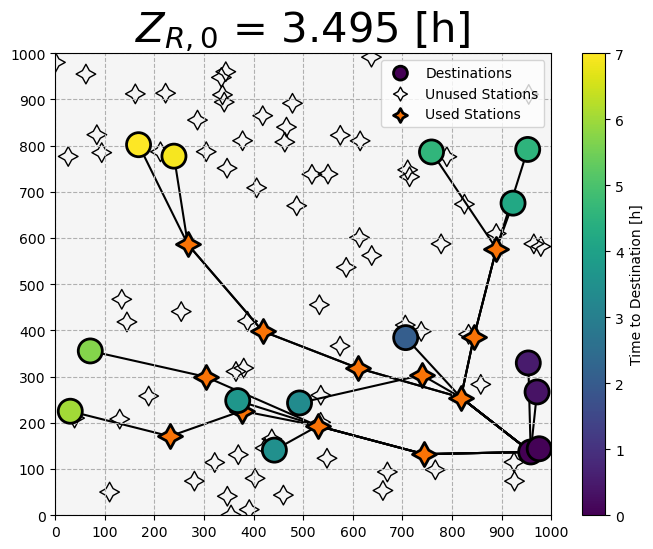

In [37]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

expectation = lambda x: super_quantile(x, vehicle.risk_attitude)
# expectation = lambda x: x.mean()

impedance = src.routing.impedance(
    {'destination_0': values},
    origins = {'destination_0': unweighted['destination_0']},
    destinations = unweighted,
    constant = 1 / 3600,
    expectation = expectation
)

src.figures.plot_route_tree(
    ax, graph,
    
    values = {k: expectation(v['time'])/ 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$Z_{R,0}$' + f' = {impedance:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_high_reliability_cautious_perceived.png',
    bbox_inches = 'tight',
    dpi = 300,
)

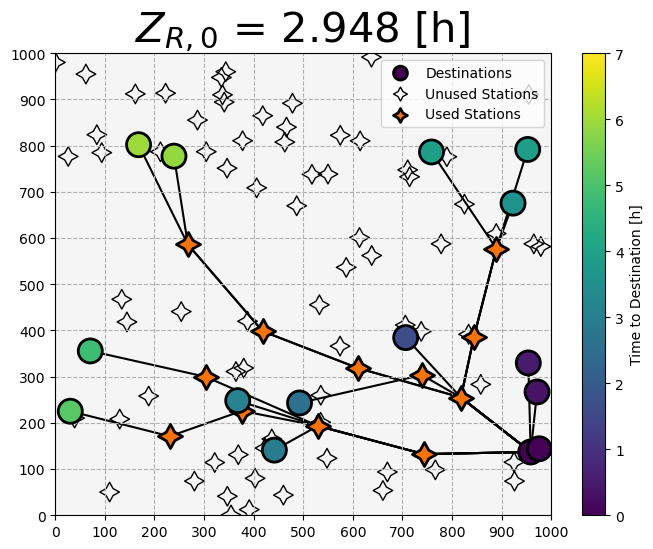

In [38]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

# expectation = lambda x: super_quantile(x, vehicle.risk_attitude)
expectation = lambda x: x.mean()

impedance = src.routing.impedance(
    {'destination_0': values},
    origins = {'destination_0': unweighted['destination_0']},
    destinations = unweighted,
    constant = 1 / 3600,
    expectation = expectation
)

src.figures.plot_route_tree(
    ax, graph,
    
    values = {k: expectation(v['time'])/ 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$Z_{R,0}$' + f' = {impedance:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_high_reliability_cautious_actual.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [39]:
'''
Adding station objects
'''
deep_reload(src)

kw = {
    'cases': 100,
    'reliability': .75,
    'rng': np.random.default_rng(seed),
    'base_delay': 300,
}

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **kw,
        )

    else:

        node['population'] = 1e6



In [40]:
'''
Running with Dijkstra with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (0, .1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'dijkstra',
    'origins': ['destination_0'],
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.5759 seconds


In [41]:
n_chargers = 0
n_stations = 0

for path in paths.values():
    for node in path:

        node = graph._node[node]

        if node.get('n_dcfc', 0) > 0:

            n_stations += 1
            n_chargers += node['n_dcfc']

n_chargers, n_stations, n_chargers / n_stations

(125, 31, 4.032258064516129)

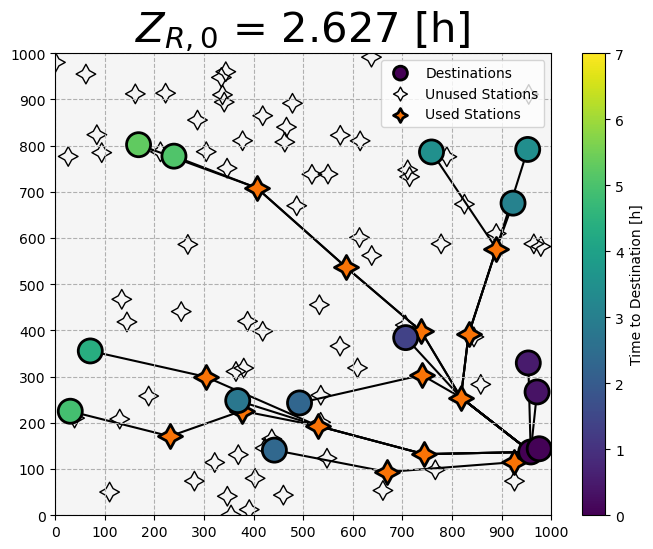

In [42]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

expectation = lambda x: super_quantile(x, vehicle.risk_attitude)
# expectation = lambda x: x.mean()

impedance = src.routing.impedance(
    {'destination_0': values},
    origins = {'destination_0': unweighted['destination_0']},
    destinations = unweighted,
    constant = 1 / 3600,
    expectation = expectation
)

src.figures.plot_route_tree(
    ax, graph,
    
    values = {k: expectation(v['time'])/ 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$Z_{R,0}$' + f' = {impedance:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_low_reliability_aggressive_perceived.png',
    bbox_inches = 'tight',
    dpi = 300,
)

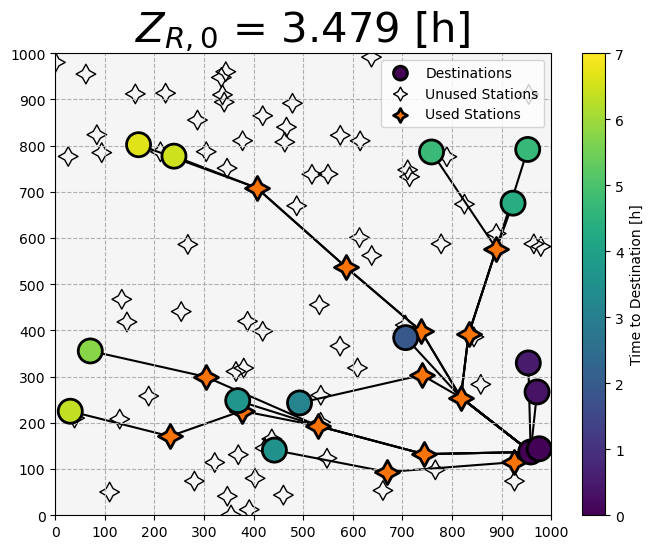

In [43]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

# expectation = lambda x: super_quantile(x, vehicle.risk_attitude)
expectation = lambda x: x.mean()

impedance = src.routing.impedance(
    {'destination_0': values},
    origins = {'destination_0': unweighted['destination_0']},
    destinations = unweighted,
    constant = 1 / 3600,
    expectation = expectation
)

src.figures.plot_route_tree(
    ax, graph,
    
    values = {k: expectation(v['time'])/ 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$Z_{R,0}$' + f' = {impedance:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_low_reliability_aggressive_actual.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [44]:
'''
Adding station objects
'''
deep_reload(src)

kw = {
    'cases': 100,
    'reliability': .75,
    'rng': np.random.default_rng(seed),
    'base_delay': 300,
}

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **kw,
        )

    else:

        node['population'] = 1e6



In [45]:
'''
Running with Dijkstra with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (.9, 1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'dijkstra',
    'origins': ['destination_0'],
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.6193 seconds


In [46]:
n_chargers = 0
n_stations = 0

for path in paths.values():
    for node in path:

        node = graph._node[node]

        if node.get('n_dcfc', 0) > 0:

            n_stations += 1
            n_chargers += node['n_dcfc']

n_chargers, n_stations, n_chargers / n_stations

(152, 34, 4.470588235294118)

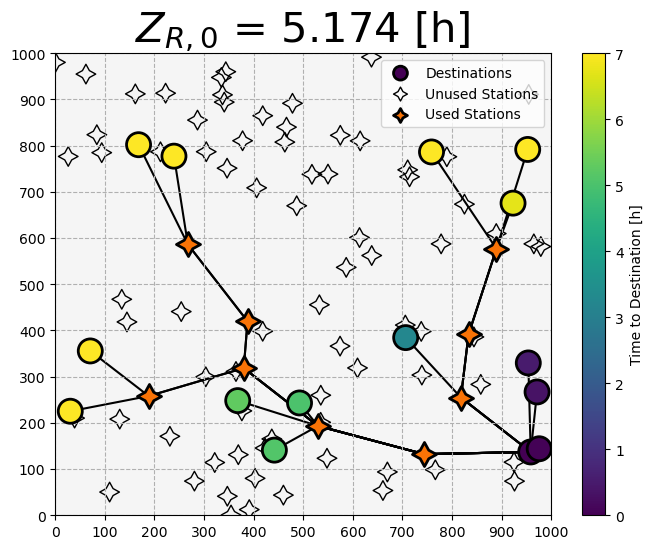

In [47]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

expectation = lambda x: super_quantile(x, vehicle.risk_attitude)
# expectation = lambda x: x.mean()

impedance = src.routing.impedance(
    {'destination_0': values},
    origins = {'destination_0': unweighted['destination_0']},
    destinations = unweighted,
    constant = 1 / 3600,
    expectation = expectation
)

src.figures.plot_route_tree(
    ax, graph,
    
    values = {k: expectation(v['time'])/ 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$Z_{R,0}$' + f' = {impedance:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_low_reliability_cautious_perceived.png',
    bbox_inches = 'tight',
    dpi = 300,
)

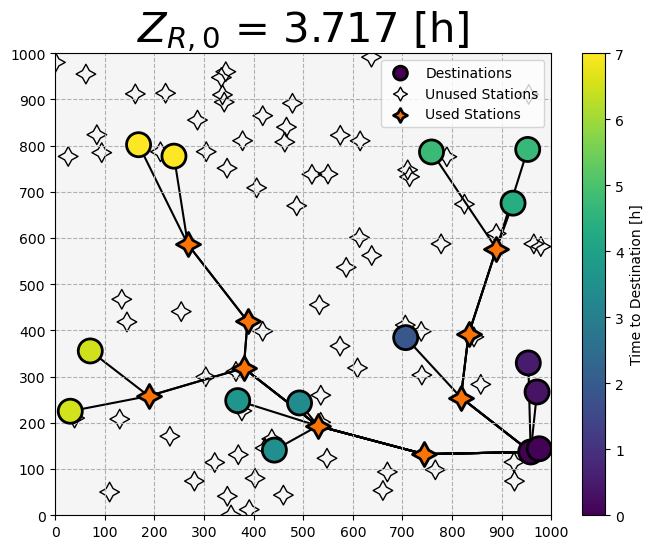

In [48]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

# expectation = lambda x: super_quantile(x, vehicle.risk_attitude)
expectation = lambda x: x.mean()

impedance = src.routing.impedance(
    {'destination_0': values},
    origins = {'destination_0': unweighted['destination_0']},
    destinations = unweighted,
    constant = 1 / 3600,
    expectation = expectation
)

src.figures.plot_route_tree(
    ax, graph,
    
    values = {k: expectation(v['time'])/ 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$Z_{R,0}$' + f' = {impedance:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_low_reliability_cautious_actual.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [49]:
(1 - vehicle.risk_attitude[1], 1 - vehicle.risk_attitude[0]), vehicle.risk_attitude

((0, 0.09999999999999998), (0.9, 1))